In [2]:
from __future__ import division
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import math
import matplotlib.pyplot as plt
import um21_lagmodel as uml
#import um_lagmodel_020421b as uml
#%matplotlib inline
%matplotlib notebook

# Set up list of colours that are more colour-blind accessible.
CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

Coronal radius reset to nearest radial bin edge:  9.939835534143139


<IPython.core.display.Javascript object>


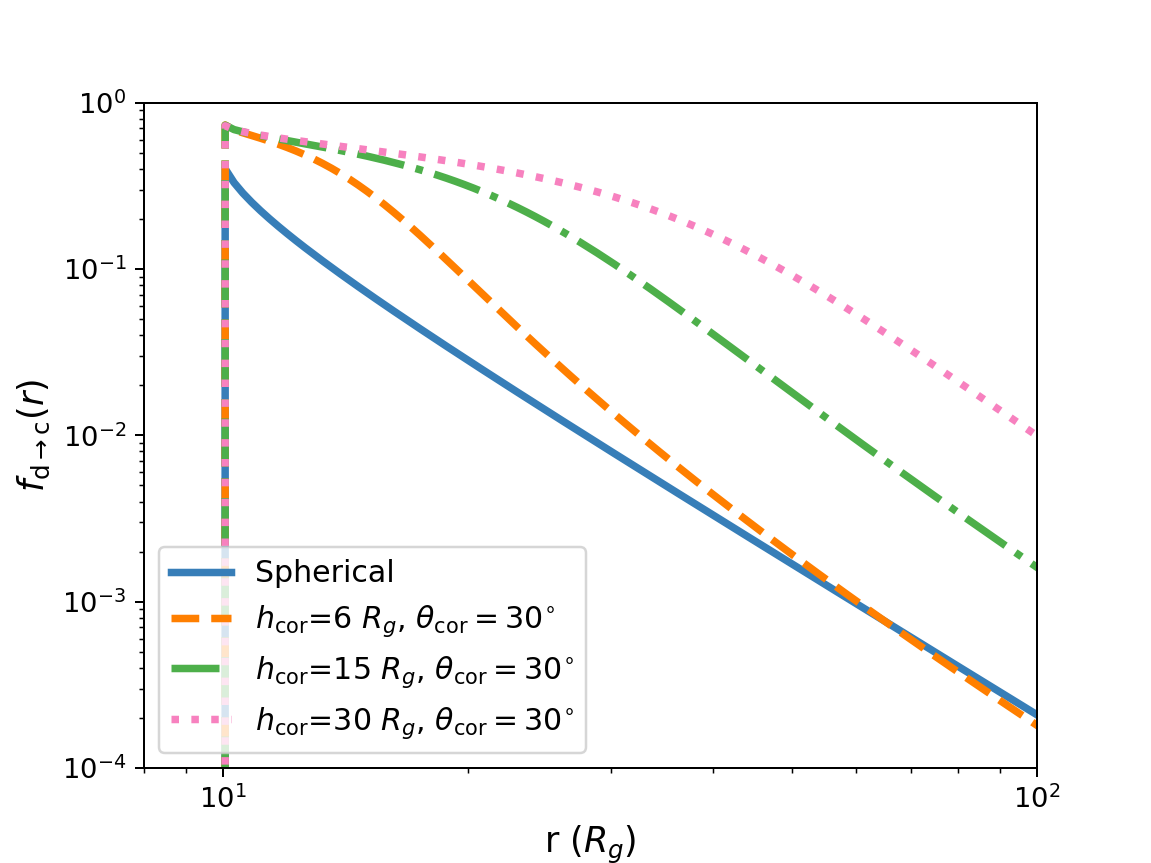

In [22]:
def plot_fdisk2cor(rad,disktocor_frac_sph,fdisk2cor_array,label_list,lstylist,leg_title,figfile):
    plt.figure()
    plt.plot(rad,disktocor_frac_sph,color=CBcol[0],label='Spherical',linewidth=3,linestyle='solid')
    for i in range(np.shape(fdisk2cor_array)[0]):
        plt.plot(rad,fdisk2cor_array[i,:],color=CBcol[i+1],label=label_list[i],linewidth=3,linestyle=lstylist[i])
    plt.xlabel(r'r ($R_{g}$)',fontsize=14)
    plt.ylabel(r'$f_{\rm d\rightarrow c}(r)$', fontsize=14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(8,100)
    plt.ylim(1e-4,1.0)
    plt.legend(fontsize=12,title=leg_title)
    plt.savefig(figfile,bbox_inches='tight')
    plt.show()
    return


# Make plots of disktocor_frac and cortodisk_frac
#First set up radial grid
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)

print("Coronal radius reset to nearest radial bin edge: ",rcor)

cor_geometry = uml.an_sphere
geopar = [rcor]
omega_cor, disktocor_frac_sph, cortodisk_frac_sph = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)

cor_geometry = uml.inv_cone

rcor = 10.0
hcorlist = [6.0,15.0,30.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
label_list = []
lstylist = ['dashed','dashdot','dotted']
#figfile = 'figs/fdisk2cor_invcone_mono_hcorcompare.pdf'
figfile = None
leg_title = None
disktocor_frac_array = np.zeros((len(hcorlist),len(rad)))

for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    labeltxt = r"$h_{\rm cor}$="+str(round(hcorval))+r" $R_{g}$, $\theta_{\rm cor}=30^{\circ}$"
    label_list.append(labeltxt)
    omega_cor, disktocor_frac_array[i,:], cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,
                                                                                      cor_geometry,geopar)
    


plot_fdisk2cor(rad,disktocor_frac_sph,disktocor_frac_array,label_list,lstylist,leg_title,figfile)


<IPython.core.display.Javascript object>


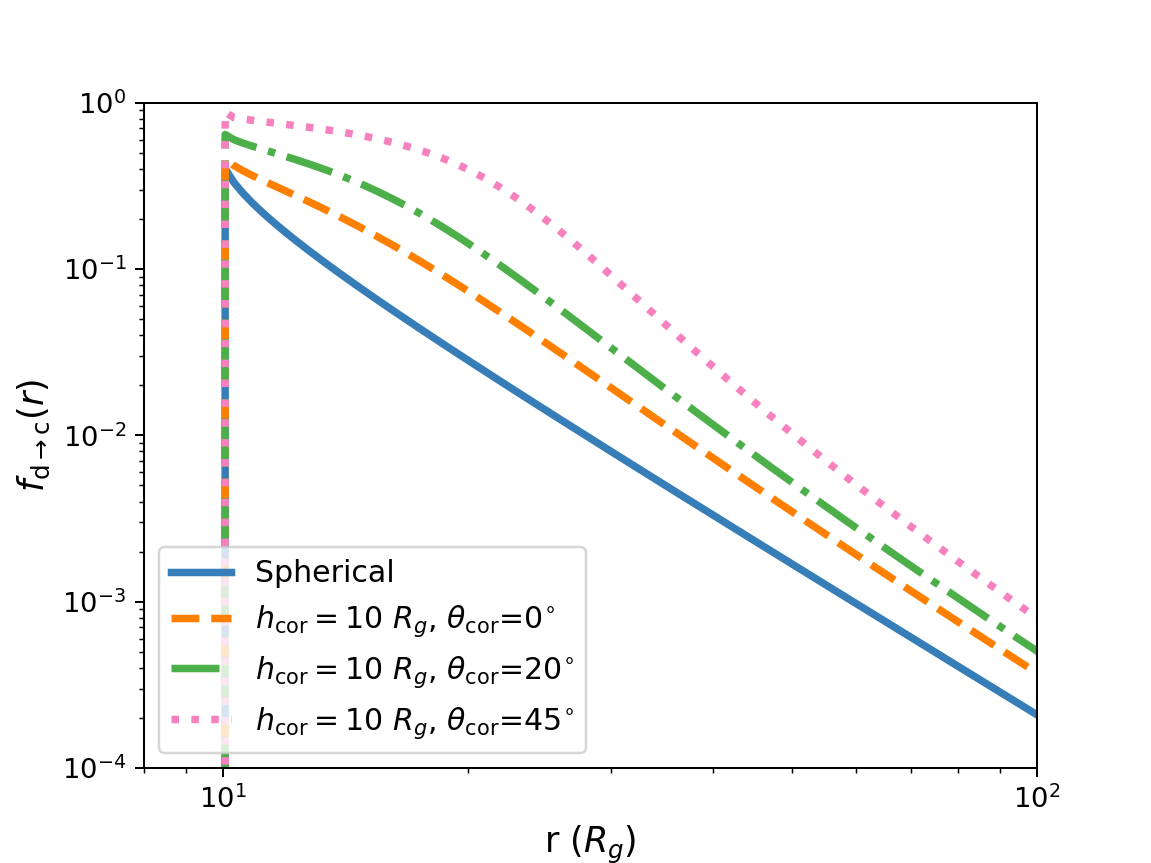

In [25]:
rcor = 10.0
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,20.,45.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
label_list = []
lstylist = ['dashed','dashdot','dotted']
#figfile = 'figs/fdisk2cor_invcone_mono_thetacorcompare.pdf'
figfile = None
leg_title = None
disktocor_frac_array = np.zeros((len(hcorlist),len(rad)))

for i, angleval in enumerate(angle_list):
    geopar = [rcor,hcorlist[i],rtoplist[i],1000,1000]
    labeltxt = r"$h_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}$="+str(round(angle_list[i]))+r"$^{\circ}$" 
    label_list.append(labeltxt)
    omega_cor, disktocor_frac_array[i,:], cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,
                                                                                      cor_geometry,geopar)

plot_fdisk2cor(rad,disktocor_frac_sph,disktocor_frac_array,label_list,lstylist,leg_title,figfile)

In [2]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.inv_cone
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 10.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 30.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 300.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])
e_seed = 1.0
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([1.,3.,9.,27.])*e_seed
# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[2,0],[3,2],[4,3]])

Coronal top radius :  15.773502691896256


In [3]:
#First set up radial grid
rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
disp_frac, seed_frac_flow, heat_frac_flow = \
    uml.calc_dispfrac(rad_edge,seedff_norm,seedff_ind,heatff_norm,heatff_ind) 
# Normalised viscous dissipation and parameters for seed and heating fractions within coronal flow.

# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)

# Reset maximum signal radius to nearest radial bin value
rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
print("Coronal radius reset to nearest radial bin edge: ",rcor)
print("Maximum signal radius reset to: ",rsigmax)

# Calculate illumination of corona by disk and vice-versa
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)

cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)

print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")

# Now calculate radial dependence of timing parameters and calculate propagation delays
tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)


print("Dissipation disk luminosity: ",np.sum(ldisk_disp))
print("Dissipation seed luminosity: ",np.sum(lseed_disp))
print("Coronal heating luminosity: ",np.sum(lheat))
print("Disk luminosity due to heating by corona: ",np.sum(ldisk_rev))
print("Seed luminosity due to heating by corona: ",np.sum(lseed_rev))


Coronal radius reset to nearest radial bin edge:  9.939835534143139
Maximum signal radius reset to:  296.265462867623
0.10168203398478903  of the disk flux is intercepted by the corona
0.2830563487444646  of the coronal flux is intercepted by the disk
Dissipation disk luminosity:  0.41197833971469366
Dissipation seed luminosity:  0.10168203398478903
Coronal heating luminosity:  0.5880216602853063
Disk luminosity due to heating by corona:  0.19522500941566173
Seed luminosity due to heating by corona:  0.054928625415103106
[0.         0.         0.         0.73349788 0.6882163  0.6652772
 0.64572401] [0.         0.         0.         0.00843652 0.00831016 0.00818389
 0.00805782]


In [4]:
# Calculate IRFs for the mono-energetic case
gamma_mean, gamma_irf, flux_irf_mono, disk_irf_mono, seed_irf_mono =\
                    uml.calc_irfs_mono(gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
print("Mean gamma is:", gamma_mean)

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
        uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                                deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)

# Carry out simulations of propagating fluctuations through the disk, to check the validity of the 
# model and the effects of increasing the total rms (i.e. checks validity of linear approximation for
# power-law variations)
iseed_start = 10 # Set starting seed for random number generation
nbins = np.amax([2*nirf,65536]) # Number of light curve bins
nsims = 10   # Number of simulations to run
segnbin = np.amax([nirf//4,16384])  # Segment size for timing analysis
print("IRF has ",nirf," bins.")
print("Light curve will be simulated with ",nbins," bins.")
print("Timing products will use a light curve segment size of ",segnbin," bins.")
bfac = 1.05  # Minimum requency binning factor for spectral-timing products
expquery = 'y'  # Should exponentiate the individual radial mdot light curves? (ensures non-negative mdots)
multquery = 'y' # Should multiply radial mdot variations together, rather than add (Lyubarskii model)


bin_freq, bin_psd_ref, bin_psd_referr, bin_psd_ciarr, bin_psd_cierrarr, bin_phlagarr, bin_tlagarr = \
uml.run_simulation(rad,iseed_start,nsims,nbins,expquery,multquery,dt,deltau_scale,nirf,segnbin,bfac,\
                   lfreq,q,rms,gamma_par,e_seed,\
                   ens_mono,encomb,i_rsigmax,irf_nbins,irf_binedgefrac,ldisk_disp,lseed_disp,lheat,\
                   rcor,disktocor_frac,cortodisk_frac)



Mean gamma is: 1.8681097884637028
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.0010000306442932059
The maximum propagation delay is:  17.215485885700527  and there are  262144  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.6072026370239089 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [4 3]
#######################################
IRF has  262144  bins.
Light curve will be simulated with  524288  bins.
Timing products will use a light curve segment size of  65536  bins.
Minimum and maximum bins:  34428 489860
Simulating radius  199 , r =  296.265462867623 , deltau =  0.6388011650925339
Fractional rms of simulated light curve =  0.03491258272007825
Mdot lengths 524288 524288
Simulating radius  198 , r =  288.9352775596728 , deltau =  0.61524063

Simulating radius  155 , r =  98.38773202271507 , deltau =  0.12225189058755075
Fractional rms of simulated light curve =  0.034613697571409835
Mdot lengths 524288 524288
Simulating radius  154 , r =  95.95342766345976 , deltau =  0.11774294646369833
Fractional rms of simulated light curve =  0.03309611646352404
Mdot lengths 524288 524288
Simulating radius  153 , r =  93.57935274126596 , deltau =  0.11340030305727426
Fractional rms of simulated light curve =  0.035494367230281036
Mdot lengths 524288 524288
Simulating radius  152 , r =  91.26401706240549 , deltau =  0.10921782679734852
Fractional rms of simulated light curve =  0.031451891185456
Mdot lengths 524288 524288
Simulating radius  151 , r =  89.00596730344901 , deltau =  0.10518961033385404
Fractional rms of simulated light curve =  0.033416023162760974
Mdot lengths 524288 524288
Simulating radius  150 , r =  86.80378609902304 , deltau =  0.10130996419401776
Fractional rms of simulated light curve =  0.03227612958590708
Mdot l

Fractional rms of simulated light curve =  0.03467474461054538
Mdot lengths 524288 524288
Simulating radius  106 , r =  28.826943115822377 , deltau =  0.01938840336379537
Fractional rms of simulated light curve =  0.03408511177760218
Mdot lengths 524288 524288
Simulating radius  105 , r =  28.11370832680773 , deltau =  0.018673312357856697
Fractional rms of simulated light curve =  0.0347453421781777
Mdot lengths 524288 524288
Simulating radius  104 , r =  27.41812035737491 , deltau =  0.017984595630253005
Fractional rms of simulated light curve =  0.033943295560102615
Mdot lengths 524288 524288
Simulating radius  103 , r =  26.739742590793853 , deltau =  0.017321280434085415
Fractional rms of simulated light curve =  0.034851332727016106
Mdot lengths 524288 524288
Simulating radius  102 , r =  26.078149213083847 , deltau =  0.01668242989970467
Fractional rms of simulated light curve =  0.03395890169017606
Mdot lengths 524288 524288
Simulating radius  101 , r =  25.43292494573246 , del

Simulating radius  196 , r =  274.8145089055388 , deltau =  0.5706944462920335
Fractional rms of simulated light curve =  0.03425506417771999
Mdot lengths 524288 524288
Simulating radius  195 , r =  268.0150620307912 , deltau =  0.54964586080384
Fractional rms of simulated light curve =  0.033121229108987106
Mdot lengths 524288 524288
Simulating radius  194 , r =  261.3838467315402 , deltau =  0.5293735978362983
Fractional rms of simulated light curve =  0.030856008338169476
Mdot lengths 524288 524288
Simulating radius  193 , r =  254.91670063053425 , deltau =  0.5098490247452949
Fractional rms of simulated light curve =  0.032679701970248644
Mdot lengths 524288 524288
Simulating radius  192 , r =  248.6095643358524 , deltau =  0.4910445649277172
Fractional rms of simulated light curve =  0.03556440430835233
Mdot lengths 524288 524288
Simulating radius  191 , r =  242.45847889284602 , deltau =  0.4729336588718436
Fractional rms of simulated light curve =  0.03169188569635625
Mdot lengt

Simulating radius  147 , r =  80.51880100045038 , deltau =  0.0905086544593249
Fractional rms of simulated light curve =  0.03394668548871519
Mdot lengths 524288 524288
Simulating radius  146 , r =  78.52660884145075 , deltau =  0.08717047732585828
Fractional rms of simulated light curve =  0.03276984625298843
Mdot lengths 524288 524288
Simulating radius  145 , r =  76.58370740150144 , deltau =  0.0839554202038519
Fractional rms of simulated light curve =  0.03495201918331541
Mdot lengths 524288 524288
Simulating radius  144 , r =  74.68887713208973 , deltau =  0.08085894213079839
Fractional rms of simulated light curve =  0.03459120818056205
Mdot lengths 524288 524288
Simulating radius  143 , r =  72.8409286587114 , deltau =  0.0778766696258118
Fractional rms of simulated light curve =  0.03420805302005348
Mdot lengths 524288 524288
Simulating radius  142 , r =  71.03870203430697 , deltau =  0.07500439051252328
Fractional rms of simulated light curve =  0.0327604028606279
Mdot lengths

Simulating radius  99 , r =  24.18997374783844 , deltau =  0.01490380828131224
Fractional rms of simulated light curve =  0.03385591627445864
Mdot lengths 524288 524288
Simulating radius  98 , r =  23.591466623687634 , deltau =  0.01435411994152372
Fractional rms of simulated light curve =  0.034380061124572765
Mdot lengths 524288 524288
Simulating radius  97 , r =  23.007767732955905 , deltau =  0.013824705431429917
Fractional rms of simulated light curve =  0.034135435716809465
Mdot lengths 524288 524288
Simulating radius  96 , r =  22.43851069107046 , deltau =  0.013314817003369716
Fractional rms of simulated light curve =  0.03440328101931941
Mdot lengths 524288 524288
Simulating radius  95 , r =  21.883338178527342 , deltau =  0.012823734488415992
Fractional rms of simulated light curve =  0.03480151170473207
Mdot lengths 524288 524288
Simulating radius  94 , r =  21.341901716603935 , deltau =  0.012350764279207057
Fractional rms of simulated light curve =  0.03449224472452543
Mdo

Simulating radius  188 , r =  224.90339293005442 , deltau =  0.4225111463966203
Fractional rms of simulated light curve =  0.032086594707901026
Mdot lengths 524288 524288
Simulating radius  187 , r =  219.3388443977787 , deltau =  0.4069279178538767
Fractional rms of simulated light curve =  0.03747159006577698
Mdot lengths 524288 524288
Simulating radius  186 , r =  213.91197364779265 , deltau =  0.39191943630631476
Fractional rms of simulated light curve =  0.03458221849314195
Mdot lengths 524288 524288
Simulating radius  185 , r =  208.6193742632727 , deltau =  0.3774645037006374
Fractional rms of simulated light curve =  0.03319739247445229
Mdot lengths 524288 524288
Simulating radius  184 , r =  203.45772410879044 , deltau =  0.36354270381890674
Fractional rms of simulated light curve =  0.03465070930810457
Mdot lengths 524288 524288
Simulating radius  183 , r =  198.42378324502656 , deltau =  0.3501343734423519
Fractional rms of simulated light curve =  0.033235142013859215
Mdot 

Simulating radius  139 , r =  65.8951800317271 , deltau =  0.06700768791931852
Fractional rms of simulated light curve =  0.034267962748547424
Mdot lengths 524288 524288
Simulating radius  138 , r =  64.26480477347728 , deltau =  0.06453628302533415
Fractional rms of simulated light curve =  0.03479626315063722
Mdot lengths 524288 524288
Simulating radius  137 , r =  62.67476817856267 , deltau =  0.06215602949531512
Fractional rms of simulated light curve =  0.032992251534170076
Mdot lengths 524288 524288
Simulating radius  136 , r =  61.124072189786666 , deltau =  0.05986356544745354
Fractional rms of simulated light curve =  0.033260821490708456
Mdot lengths 524288 524288
Simulating radius  135 , r =  59.61174344383406 , deltau =  0.0576556529942376
Fractional rms of simulated light curve =  0.0344262543254755
Mdot lengths 524288 524288
Simulating radius  134 , r =  58.136832660296214 , deltau =  0.055529173669248796
Fractional rms of simulated light curve =  0.03388166934575325
Mdot

Simulating radius  91 , r =  19.796651903294602 , deltau =  0.011033969514731175
Fractional rms of simulated light curve =  0.033945098222628325
Mdot lengths 524288 524288
Simulating radius  90 , r =  19.30684412913304 , deltau =  0.010627010147746061
Fractional rms of simulated light curve =  0.03469198379284944
Mdot lengths 524288 524288
Simulating radius  89 , r =  18.829155154493797 , deltau =  0.010235060422228028
Fractional rms of simulated light curve =  0.034131695060361004
Mdot lengths 524288 524288
Simulating radius  88 , r =  18.363285136643434 , deltau =  0.009857566746455111
Fractional rms of simulated light curve =  0.034290252128420275
Mdot lengths 524288 524288
Simulating radius  87 , r =  17.908941651542474 , deltau =  0.009493995946499984
Fractional rms of simulated light curve =  0.034285178535108034
Mdot lengths 524288 524288
Simulating radius  86 , r =  17.465839510292444 , deltau =  0.009143834513174664
Fractional rms of simulated light curve =  0.0341792476510903

Simulating radius  180 , r =  184.05700758993285 , deltau =  0.31280428605755994
Fractional rms of simulated light curve =  0.03504478124957382
Mdot lengths 524288 524288
Simulating radius  179 , r =  179.50307828679345 , deltau =  0.30126731071297513
Fractional rms of simulated light curve =  0.032600244090404
Mdot lengths 524288 524288
Simulating radius  178 , r =  175.06182207537475 , deltau =  0.29015584680169876
Fractional rms of simulated light curve =  0.038693106134635946
Mdot lengths 524288 524288
Simulating radius  177 , r =  170.73045120365998 , deltau =  0.2794542004373809
Fractional rms of simulated light curve =  0.03462306257764417
Mdot lengths 524288 524288
Simulating radius  176 , r =  166.5062468940541 , deltau =  0.2691472565619578
Fractional rms of simulated light curve =  0.03241099532371471
Mdot lengths 524288 524288
Simulating radius  175 , r =  162.38655763682172 , deltau =  0.25922045759719065
Fractional rms of simulated light curve =  0.03397192872901188
Mdot 

Simulating radius  131 , r =  53.9274641134986 , deltau =  0.049608849751607266
Fractional rms of simulated light curve =  0.03332662345937157
Mdot lengths 524288 524288
Simulating radius  130 , r =  52.59319348568531 , deltau =  0.04777915590798851
Fractional rms of simulated light curve =  0.034642958280581254
Mdot lengths 524288 524288
Simulating radius  129 , r =  51.29193531520727 , deltau =  0.04601694557947252
Fractional rms of simulated light curve =  0.03434665016680322
Mdot lengths 524288 524288
Simulating radius  128 , r =  50.022872809491375 , deltau =  0.04431972981151082
Fractional rms of simulated light curve =  0.03408930052894401
Mdot lengths 524288 524288
Simulating radius  127 , r =  48.78520938500562 , deltau =  0.042685111448195416
Fractional rms of simulated light curve =  0.035782475233279994
Mdot lengths 524288 524288
Simulating radius  126 , r =  47.57816816724805 , deltau =  0.041110781746499486
Fractional rms of simulated light curve =  0.03380022120728798
Md

Simulating radius  83 , r =  16.201234059430842 , deltau =  0.00816895124749262
Fractional rms of simulated light curve =  0.03389729223786646
Mdot lengths 524288 524288
Simulating radius  82 , r =  15.800383934263985 , deltau =  0.007867660653552416
Fractional rms of simulated light curve =  0.033680422240092836
Mdot lengths 524288 524288
Simulating radius  81 , r =  15.409451622904204 , deltau =  0.00757748238226494
Fractional rms of simulated light curve =  0.034595081402446194
Mdot lengths 524288 524288
Simulating radius  80 , r =  15.028191739296872 , deltau =  0.007298006584410682
Fractional rms of simulated light curve =  0.034582510565120156
Mdot lengths 524288 524288
Simulating radius  79 , r =  14.65636496871689 , deltau =  0.007028838526996867
Fractional rms of simulated light curve =  0.03400188312420841
Mdot lengths 524288 524288
Simulating radius  78 , r =  14.293737917552141 , deltau =  0.006769598035733192
Fractional rms of simulated light curve =  0.034256470798529365


Simulating radius  172 , r =  150.6290394360411 , deltau =  0.23158329007520456
Fractional rms of simulated light curve =  0.03559995337742908
Mdot lengths 524288 524288
Simulating radius  171 , r =  146.902183253962 , deltau =  0.22304194065352737
Fractional rms of simulated light curve =  0.03536529377852971
Mdot lengths 524288 524288
Simulating radius  170 , r =  143.26753676168707 , deltau =  0.21481561676725933
Fractional rms of simulated light curve =  0.03389572680503156
Mdot lengths 524288 524288
Simulating radius  169 , r =  139.7228185116696 , deltau =  0.20689269951599315
Fractional rms of simulated light curve =  0.03806145212925297
Mdot lengths 524288 524288
Simulating radius  168 , r =  136.26580350382423 , deltau =  0.1992619985324127
Fractional rms of simulated light curve =  0.03416448775864101
Mdot lengths 524288 524288
Simulating radius  167 , r =  132.8943217889067 , deltau =  0.1919127361768645
Fractional rms of simulated light curve =  0.03267440376855979
Mdot len

Simulating radius  123 , r =  44.13329448849613 , deltau =  0.036727695733074744
Fractional rms of simulated light curve =  0.03436069236688101
Mdot lengths 524288 524288
Simulating radius  122 , r =  43.041350717123876 , deltau =  0.03537308986921066
Fractional rms of simulated light curve =  0.03412294374729283
Mdot lengths 524288 524288
Simulating radius  121 , r =  41.9764237640893 , deltau =  0.03406844513167847
Fractional rms of simulated light curve =  0.0339390309029073
Mdot lengths 524288 524288
Simulating radius  120 , r =  40.937845180620386 , deltau =  0.03281191883382626
Fractional rms of simulated light curve =  0.03448166481605022
Mdot lengths 524288 524288
Simulating radius  119 , r =  39.924963056671274 , deltau =  0.03160173625172404
Fractional rms of simulated light curve =  0.03480520956436946
Mdot lengths 524288 524288
Simulating radius  118 , r =  38.93714161172198 , deltau =  0.030436188117531435
Fractional rms of simulated light curve =  0.033662807703194915
Mdo

Simulating radius  75 , r =  13.25880690990881 , deltau =  0.006047847458235072
Fractional rms of simulated light curve =  0.03438817279512484
Mdot lengths 524288 524288
Simulating radius  74 , r =  12.93075817054094 , deltau =  0.005824788279945821
Fractional rms of simulated light curve =  0.03392985515584254
Mdot lengths 524288 524288
Simulating radius  73 , r =  12.610825996723202 , deltau =  0.005609956061308276
Fractional rms of simulated light curve =  0.03436543980883233
Mdot lengths 524288 524288
Simulating radius  72 , r =  12.298809568795516 , deltau =  0.005403047372238892
Fractional rms of simulated light curve =  0.03408347318468198
Mdot lengths 524288 524288
Simulating radius  71 , r =  11.994513035767822 , deltau =  0.005203769973886329
Fractional rms of simulated light curve =  0.03428243961659366
Mdot lengths 524288 524288
Simulating radius  70 , r =  11.697745392385485 , deltau =  0.00501184240587171
Fractional rms of simulated light curve =  0.03424388991429099
Mdot

Simulating radius  164 , r =  123.27217430359555 , deltau =  0.171451679636465
Fractional rms of simulated light curve =  0.035829505402577594
Mdot lengths 524288 524288
Simulating radius  163 , r =  120.22218031437706 , deltau =  0.16512812881278052
Fractional rms of simulated light curve =  0.03369772673077327
Mdot lengths 524288 524288
Simulating radius  162 , r =  117.24764912434108 , deltau =  0.1590378057714397
Fractional rms of simulated light curve =  0.03229857835655975
Mdot lengths 524288 524288
Simulating radius  161 , r =  114.34671363667348 , deltau =  0.15317210851016821
Fractional rms of simulated light curve =  0.03492278487487995
Mdot lengths 524288 524288
Simulating radius  160 , r =  111.51755295017645 , deltau =  0.1475227522892864
Fractional rms of simulated light curve =  0.0340421055338699
Mdot lengths 524288 524288
Simulating radius  159 , r =  108.75839121629862 , deltau =  0.1420817579302446
Fractional rms of simulated light curve =  0.035569011061646616
Mdot 

Simulating radius  115 , r =  36.117917176839406 , deltau =  0.027191189487669527
Fractional rms of simulated light curve =  0.0345377378024262
Mdot lengths 524288 524288
Simulating radius  114 , r =  35.22428947119717 , deltau =  0.02618831293932551
Fractional rms of simulated light curve =  0.034584401396580394
Mdot lengths 524288 524288
Simulating radius  113 , r =  34.352771857684026 , deltau =  0.025222424893145117
Fractional rms of simulated light curve =  0.034279228260225524
Mdot lengths 524288 524288
Simulating radius  112 , r =  33.502817289503135 , deltau =  0.024292161124096455
Fractional rms of simulated light curve =  0.034379786319925984
Mdot lengths 524288 524288
Simulating radius  111 , r =  32.67389225486219 , deltau =  0.02339620772305024
Fractional rms of simulated light curve =  0.033978379182609625
Mdot lengths 524288 524288
Simulating radius  110 , r =  31.865476442091083 , deltau =  0.02253329924101041
Fractional rms of simulated light curve =  0.033783211395694

Simulating radius  67 , r =  10.850775936535134 , deltau =  0.0044774975109942786
Fractional rms of simulated light curve =  0.0343484645076533
Mdot lengths 524288 524288
Simulating radius  66 , r =  10.582306579425529 , deltau =  0.004312356620372931
Fractional rms of simulated light curve =  0.03452097268270098
Mdot lengths 524288 524288
Simulating radius  65 , r =  10.320479677761364 , deltau =  0.004153306523479057
Fractional rms of simulated light curve =  0.034122939400369465
Mdot lengths 524288 524288
Simulating radius  64 , r =  10.065130884241253 , deltau =  0.0040001225771728235
Fractional rms of simulated light curve =  0.03455589633925779
Mdot lengths 524288 524288
Simulating radius  63 , r =  9.816099917836546 , deltau =  0.0
Mdot lengths 524288 524288
Simulated  6  light curves
rms values, disk disp:  0.09731798194096121  seed disp:  0.0343832753023517  heat:  0.23552306492221334
disk due to heating:  0.07535766578517415  seed due to heating:  0.02120267791744459
Simulati

Simulating radius  156 , r =  100.88379381844541 , deltau =  0.12693350388372335
Fractional rms of simulated light curve =  0.03483643056364724
Mdot lengths 524288 524288
Simulating radius  155 , r =  98.38773202271507 , deltau =  0.12225189058755075
Fractional rms of simulated light curve =  0.0334893358259898
Mdot lengths 524288 524288
Simulating radius  154 , r =  95.95342766345976 , deltau =  0.11774294646369833
Fractional rms of simulated light curve =  0.03314444718723339
Mdot lengths 524288 524288
Simulating radius  153 , r =  93.57935274126596 , deltau =  0.11340030305727426
Fractional rms of simulated light curve =  0.03384455938548841
Mdot lengths 524288 524288
Simulating radius  152 , r =  91.26401706240549 , deltau =  0.10921782679734852
Fractional rms of simulated light curve =  0.035327414005625356
Mdot lengths 524288 524288
Simulating radius  151 , r =  89.00596730344901 , deltau =  0.10518961033385404
Fractional rms of simulated light curve =  0.03493320175096409
Mdot l

Simulating radius  107 , r =  29.55827241796022 , deltau =  0.02013087864612648
Fractional rms of simulated light curve =  0.034327808759600106
Mdot lengths 524288 524288
Simulating radius  106 , r =  28.826943115822377 , deltau =  0.01938840336379537
Fractional rms of simulated light curve =  0.03438691494421335
Mdot lengths 524288 524288
Simulating radius  105 , r =  28.11370832680773 , deltau =  0.018673312357856697
Fractional rms of simulated light curve =  0.03395873633906473
Mdot lengths 524288 524288
Simulating radius  104 , r =  27.41812035737491 , deltau =  0.017984595630253005
Fractional rms of simulated light curve =  0.03487800498256245
Mdot lengths 524288 524288
Simulating radius  103 , r =  26.739742590793853 , deltau =  0.017321280434085415
Fractional rms of simulated light curve =  0.03388068646921128
Mdot lengths 524288 524288
Simulating radius  102 , r =  26.078149213083847 , deltau =  0.01668242989970467
Fractional rms of simulated light curve =  0.03423276580701031


Fractional rms of simulated light curve =  0.03222858269648093
Mdot lengths 524288 524288
Simulating radius  196 , r =  274.8145089055388 , deltau =  0.5706944462920335
Fractional rms of simulated light curve =  0.03480297863530838
Mdot lengths 524288 524288
Simulating radius  195 , r =  268.0150620307912 , deltau =  0.54964586080384
Fractional rms of simulated light curve =  0.03172569816204003
Mdot lengths 524288 524288
Simulating radius  194 , r =  261.3838467315402 , deltau =  0.5293735978362983
Fractional rms of simulated light curve =  0.03358062770164754
Mdot lengths 524288 524288
Simulating radius  193 , r =  254.91670063053425 , deltau =  0.5098490247452949
Fractional rms of simulated light curve =  0.032875780788379584
Mdot lengths 524288 524288
Simulating radius  192 , r =  248.6095643358524 , deltau =  0.4910445649277172
Fractional rms of simulated light curve =  0.02931998128100598
Mdot lengths 524288 524288
Simulating radius  191 , r =  242.45847889284602 , deltau =  0.47

Fractional rms of simulated light curve =  0.034528652610360075
Mdot lengths 524288 524288
Simulating radius  147 , r =  80.51880100045038 , deltau =  0.0905086544593249
Fractional rms of simulated light curve =  0.03452266124515791
Mdot lengths 524288 524288
Simulating radius  146 , r =  78.52660884145075 , deltau =  0.08717047732585828
Fractional rms of simulated light curve =  0.034308955735411116
Mdot lengths 524288 524288
Simulating radius  145 , r =  76.58370740150144 , deltau =  0.0839554202038519
Fractional rms of simulated light curve =  0.03464822764298284
Mdot lengths 524288 524288
Simulating radius  144 , r =  74.68887713208973 , deltau =  0.08085894213079839
Fractional rms of simulated light curve =  0.035638589496868295
Mdot lengths 524288 524288
Simulating radius  143 , r =  72.8409286587114 , deltau =  0.0778766696258118
Fractional rms of simulated light curve =  0.03461491482299537
Mdot lengths 524288 524288
Simulating radius  142 , r =  71.03870203430697 , deltau =  0

Fractional rms of simulated light curve =  0.03403662026561473
Mdot lengths 524288 524288
Simulating radius  99 , r =  24.18997374783844 , deltau =  0.01490380828131224
Fractional rms of simulated light curve =  0.03437645315173966
Mdot lengths 524288 524288
Simulating radius  98 , r =  23.591466623687634 , deltau =  0.01435411994152372
Fractional rms of simulated light curve =  0.03445390918310521
Mdot lengths 524288 524288
Simulating radius  97 , r =  23.007767732955905 , deltau =  0.013824705431429917
Fractional rms of simulated light curve =  0.034755636244063665
Mdot lengths 524288 524288
Simulating radius  96 , r =  22.43851069107046 , deltau =  0.013314817003369716
Fractional rms of simulated light curve =  0.03414358763451242
Mdot lengths 524288 524288
Simulating radius  95 , r =  21.883338178527342 , deltau =  0.012823734488415992
Fractional rms of simulated light curve =  0.03401184422887426
Mdot lengths 524288 524288
Simulating radius  94 , r =  21.341901716603935 , deltau =

Fractional rms of simulated light curve =  0.032155564633283396
Mdot lengths 524288 524288
Simulating radius  188 , r =  224.90339293005442 , deltau =  0.4225111463966203
Fractional rms of simulated light curve =  0.03171141319091025
Mdot lengths 524288 524288
Simulating radius  187 , r =  219.3388443977787 , deltau =  0.4069279178538767
Fractional rms of simulated light curve =  0.034919363934257326
Mdot lengths 524288 524288
Simulating radius  186 , r =  213.91197364779265 , deltau =  0.39191943630631476
Fractional rms of simulated light curve =  0.03669626481914272
Mdot lengths 524288 524288
Simulating radius  185 , r =  208.6193742632727 , deltau =  0.3774645037006374
Fractional rms of simulated light curve =  0.03624683668044255
Mdot lengths 524288 524288
Simulating radius  184 , r =  203.45772410879044 , deltau =  0.36354270381890674
Fractional rms of simulated light curve =  0.0338687658745371
Mdot lengths 524288 524288
Simulating radius  183 , r =  198.42378324502656 , deltau =

Simulating radius  140 , r =  67.5669173308651 , deltau =  0.06957373480171009
Fractional rms of simulated light curve =  0.03318962923884718
Mdot lengths 524288 524288
Simulating radius  139 , r =  65.8951800317271 , deltau =  0.06700768791931852
Fractional rms of simulated light curve =  0.03339724922782692
Mdot lengths 524288 524288
Simulating radius  138 , r =  64.26480477347728 , deltau =  0.06453628302533415
Fractional rms of simulated light curve =  0.03288665798598382
Mdot lengths 524288 524288
Simulating radius  137 , r =  62.67476817856267 , deltau =  0.06215602949531512
Fractional rms of simulated light curve =  0.03524414820886499
Mdot lengths 524288 524288
Simulating radius  136 , r =  61.124072189786666 , deltau =  0.05986356544745354
Fractional rms of simulated light curve =  0.0337400877713216
Mdot lengths 524288 524288
Simulating radius  135 , r =  59.61174344383406 , deltau =  0.0576556529942376
Fractional rms of simulated light curve =  0.03387256139927186
Mdot lengt

Fractional rms of simulated light curve =  0.033974816983240515
Mdot lengths 524288 524288
Simulating radius  91 , r =  19.796651903294602 , deltau =  0.011033969514731175
Fractional rms of simulated light curve =  0.0348655258207092
Mdot lengths 524288 524288
Simulating radius  90 , r =  19.30684412913304 , deltau =  0.010627010147746061
Fractional rms of simulated light curve =  0.03412869002694229
Mdot lengths 524288 524288
Simulating radius  89 , r =  18.829155154493797 , deltau =  0.010235060422228028
Fractional rms of simulated light curve =  0.03420307055810738
Mdot lengths 524288 524288
Simulating radius  88 , r =  18.363285136643434 , deltau =  0.009857566746455111
Fractional rms of simulated light curve =  0.034128575549517565
Mdot lengths 524288 524288
Simulating radius  87 , r =  17.908941651542474 , deltau =  0.009493995946499984
Fractional rms of simulated light curve =  0.03416287795747597
Mdot lengths 524288 524288
Simulating radius  86 , r =  17.465839510292444 , delta

Fractional rms of simulated light curve =  0.03275970333742768
Mdot lengths 524288 524288
Simulating radius  180 , r =  184.05700758993285 , deltau =  0.31280428605755994
Fractional rms of simulated light curve =  0.03214239274069077
Mdot lengths 524288 524288
Simulating radius  179 , r =  179.50307828679345 , deltau =  0.30126731071297513
Fractional rms of simulated light curve =  0.0344140889708396
Mdot lengths 524288 524288
Simulating radius  178 , r =  175.06182207537475 , deltau =  0.29015584680169876
Fractional rms of simulated light curve =  0.03717530610765767
Mdot lengths 524288 524288
Simulating radius  177 , r =  170.73045120365998 , deltau =  0.2794542004373809
Fractional rms of simulated light curve =  0.03339792666561498
Mdot lengths 524288 524288
Simulating radius  176 , r =  166.5062468940541 , deltau =  0.2691472565619578
Fractional rms of simulated light curve =  0.03626200613438232
Mdot lengths 524288 524288
Simulating radius  175 , r =  162.38655763682172 , deltau =

Fractional rms of simulated light curve =  0.034271118436418974
Mdot lengths 524288 524288
Simulating radius  131 , r =  53.9274641134986 , deltau =  0.049608849751607266
Fractional rms of simulated light curve =  0.03335684446996427
Mdot lengths 524288 524288
Simulating radius  130 , r =  52.59319348568531 , deltau =  0.04777915590798851
Fractional rms of simulated light curve =  0.035360556782322784
Mdot lengths 524288 524288
Simulating radius  129 , r =  51.29193531520727 , deltau =  0.04601694557947252
Fractional rms of simulated light curve =  0.0342359093375248
Mdot lengths 524288 524288
Simulating radius  128 , r =  50.022872809491375 , deltau =  0.04431972981151082
Fractional rms of simulated light curve =  0.03394545579114387
Mdot lengths 524288 524288
Simulating radius  127 , r =  48.78520938500562 , deltau =  0.042685111448195416
Fractional rms of simulated light curve =  0.03533209277166171
Mdot lengths 524288 524288
Simulating radius  126 , r =  47.57816816724805 , deltau 

Fractional rms of simulated light curve =  0.034180712473336504
Mdot lengths 524288 524288
Simulating radius  83 , r =  16.201234059430842 , deltau =  0.00816895124749262
Fractional rms of simulated light curve =  0.03472773221679127
Mdot lengths 524288 524288
Simulating radius  82 , r =  15.800383934263985 , deltau =  0.007867660653552416
Fractional rms of simulated light curve =  0.034078809395749296
Mdot lengths 524288 524288
Simulating radius  81 , r =  15.409451622904204 , deltau =  0.00757748238226494
Fractional rms of simulated light curve =  0.034285860017736404
Mdot lengths 524288 524288
Simulating radius  80 , r =  15.028191739296872 , deltau =  0.007298006584410682
Fractional rms of simulated light curve =  0.0340639351548765
Mdot lengths 524288 524288
Simulating radius  79 , r =  14.65636496871689 , deltau =  0.007028838526996867
Fractional rms of simulated light curve =  0.03420226789359344
Mdot lengths 524288 524288
Simulating radius  78 , r =  14.293737917552141 , deltau

<IPython.core.display.Javascript object>


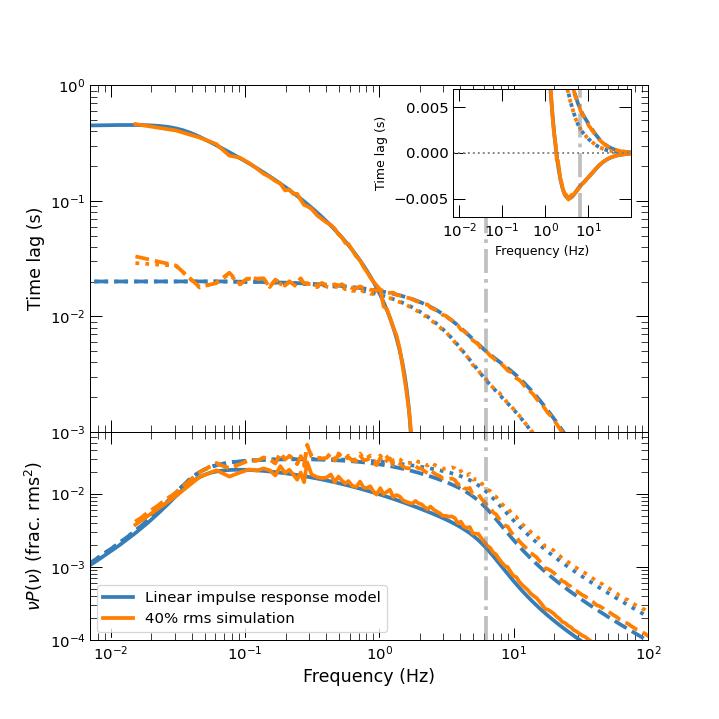

In [9]:
ls_list = ['solid','dashed','dotted']
vlines_list = []
laglist = []
psdlist = []

for j in range(3):
    if j == 0:
        labtxt = 'Linear impulse response model'
    else:
        labtxt = None
    laglist.append([freq,tlag[j,:],CBcol[0],ls_list[j],labtxt])
    if j == 0:
        psdlist.append([freq,freq*psd_ref[j,:],CBcol[0],ls_list[j],labtxt])
    else:
        psdlist.append([freq,freq*psd_ci[j,:],CBcol[0],ls_list[j],labtxt])
for j in range(3):
    if j == 0:
        labtxt = r'40% rms simulation'
    else:
        labtxt = None
    laglist.append([bin_freq,bin_tlagarr[j,:],CBcol[1],ls_list[j],labtxt])
    if j == 0:
        psdlist.append([bin_freq,bin_freq*bin_psd_ref[0,:],CBcol[1],ls_list[j],labtxt])
    else:
        psdlist.append([bin_freq,bin_freq*bin_psd_ciarr[j,:],CBcol[1],ls_list[j],labtxt])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.007,0.007]
psdlim = [0.0001,0.07]
inset_yticks = [-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$\nu P(\nu)$ (frac. rms$^{2}$)']
leg_title=None
#figfile = 'figs/lagspsd_modelsim40pcrms_compare.pdf'
figfile = None
uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)

In [10]:
cor_prop_par = [10., 0.] # As disk_prop_par but for radial propagation delays generated in the corona
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
# Now calculate radial dependence of timing parameters and calculate propagation delays
tau_cp, lfreq_cp, q_cp, rms_cp = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau_cp = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)    
# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq_cp, phlag_cp, tlag_cp, psd_ci_cp, psd_ref_cp, mod_sig_psd_cp, irf_nbins_cp, irf_binedgefrac_cp,\
        deltau_scale_cp, dt_cp, nirf_cp,\
        ci_irf_cp, ci_mean_cp, ci_outer_cp =\
        uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                                deltau_cp,min_deltau_frac,i_rsigmax,lfreq_cp,q_cp,rms_cp,t_scale)


#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  9.025878937246894e-06
The maximum propagation delay is:  17.224988706393415  and there are  16777216  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.6072033481327921 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [4 3]
#######################################


In [11]:
cor_prop_par = [10., 0.] # As disk_prop_par but for radial propagation delays generated in the corona
lor_par = [1.0,0.4,-0.1] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
# Now calculate radial dependence of timing parameters and calculate propagation delays
tau_cpcr, lfreq_cpcr, q_cpcr, rms_cpcr = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau_cpcr = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)    
# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq_cpcr, phlag_cpcr, tlag_cpcr, psd_ci_cpcr, psd_ref_cpcr, mod_sig_psd_cpcr, irf_nbins_cpcr, irf_binedgefrac_cpcr,\
        deltau_scale_cpcr, dt_cpcr, nirf_cpcr,\
        ci_irf_cpcr, ci_mean_cpcr, ci_outer_cpcr =\
        uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                                deltau_cpcr,min_deltau_frac,i_rsigmax,lfreq_cpcr,q_cpcr,rms_cpcr,t_scale)


#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  9.025878937246894e-06
The maximum propagation delay is:  17.224988706393415  and there are  16777216  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.6072033481327921 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [4 3]
#######################################


<IPython.core.display.Javascript object>


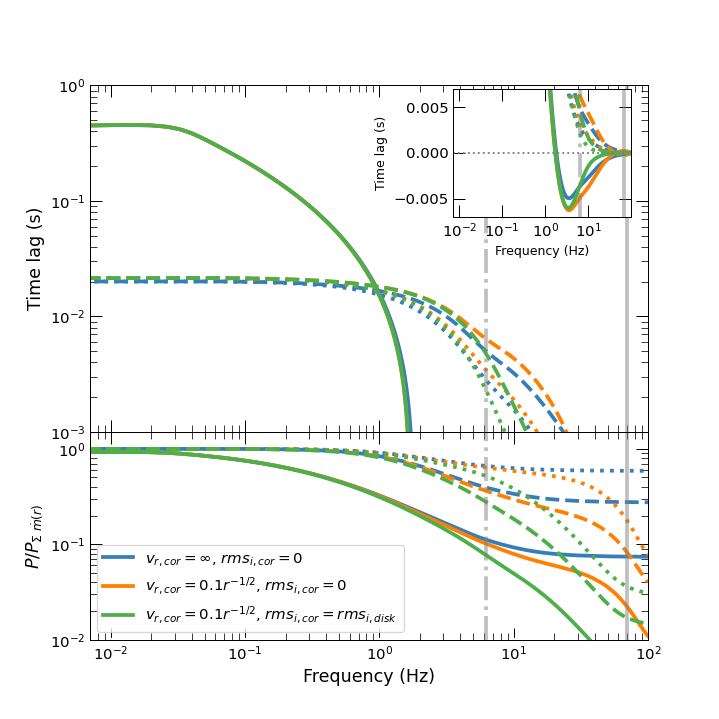

In [15]:
# Due to the small dt, the coronal propagation products are enormous arrays so to speed up plotting we use a 
# geometrically spaced array (with linear spacing for the first values)
nvals = len(psd_ref_cp[0,:])
vals = np.rint(np.geomspace(1,nvals,10000)-1)
ivals = np.unique(vals.astype(int))


ls_list = ['solid','dashed','dotted']
vlines_list = []
laglist = []
psdlist = []

for j in range(3):
    if j == 0:
        labtxt = r'$v_{r,cor} = \infty$, $rms_{i, cor} = 0$'
    else:
        labtxt = None
    laglist.append([freq,tlag[j,:],CBcol[0],ls_list[j],labtxt])
    if j == 0:
        psdlist.append([freq,psd_ref[j,:]/mod_sig_psd[0,:],CBcol[0],ls_list[j],labtxt])
    else:
        psdlist.append([freq,psd_ci[j,:]/mod_sig_psd[0,:],CBcol[0],ls_list[j],labtxt])
for j in range(3):
    if j == 0:
        labtxt = r'$v_{r,cor}=0.1 r^{-1/2}$, $rms_{i, cor} = 0$'
    else:
        labtxt = None
    laglist.append([freq_cp[ivals],tlag_cp[j,ivals],CBcol[1],ls_list[j],labtxt])
    if j == 0:
        psdlist.append([freq_cp[ivals],psd_ref_cp[j,ivals]/mod_sig_psd_cp[0,ivals],CBcol[1],ls_list[j],labtxt])
    else:
        psdlist.append([freq_cp[ivals],psd_ci_cp[j,ivals]/mod_sig_psd_cp[0,ivals],CBcol[1],ls_list[j],labtxt])
for j in range(3):
    if j == 0:
        labtxt = r'$v_{r,cor}=0.1 r^{-1/2}$, $rms_{i, cor} = rms_{i, disk}$'
    else:
        labtxt = None
    laglist.append([freq_cpcr[ivals],tlag_cpcr[j,ivals],CBcol[2],ls_list[j],labtxt])
    if j == 0:
        psdlist.append([freq_cpcr[ivals],psd_ref_cpcr[j,ivals]/mod_sig_psd_cpcr[0,ivals],CBcol[2],ls_list[j],labtxt])
    else:
        psdlist.append([freq_cpcr[ivals],psd_ci_cpcr[j,ivals]/mod_sig_psd_cpcr[0,ivals],CBcol[2],ls_list[j],labtxt])


vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
vlines_list.append([1./(tau[0]*t_scale),'gray','solid'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.007,0.007]
psdlim = [0.01,1.5]
inset_yticks = [-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
leg_title=None
figfile = 'figs/lagspsd_coronalprop_compare.pdf'
#figfile = None
uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)